# Transformer Architecture Exploration

In this notebook, I explore the Transformer architecture with a focus on its core building blocks. Transformer’s have the ability to process sequences in parallel, which is unique from the sequential nature of RNNs. This offers major improvements in training speed and scalability for deep learning tasks involving text, time series, and more.

### Objectives

- Understand how positional encodings allow the Transformer model to incorporate token order
- Implement the scaled dot-product attention mechanism
- Explore how multi-head attention improves representation learning
- Assemble a basic Transformer encoder-decoder model from scratch


## Packages

In [ ]:
import sys
import os
import random
# add src folder to path (will possibly make as package in future)
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'src')))
from tests.architecture_tests import get_angles_test, positional_encoding_test, scaled_dot_product_attention_test, EncoderLayer_test, DecoderLayer_test, Decoder_test, Transformer_test
import tensorflow as tf
import time
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Embedding, MultiHeadAttention, Dense, Input, Dropout, LayerNormalization
from transformers import DistilBertTokenizerFast #, TFDistilBertModel
from transformers import TFDistilBertForTokenClassification

In [ ]:
SEED = 10
# TensorFlow random seed
tf.random.set_seed(SEED)
# NumPy random seed
np.random.seed(SEED)
# Python random seed
random.seed(SEED)
# deterministic operations (for GPU computations)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

## 1. Positional Encoding

Unlike RNNs, Transformer models process entire input sequences at the same time, which essentially means they don’t understand the order of tokens. To overcome this issue, **positional encodings** are used to inject position-specific information into the input embeddings.

A common approach for this involves using sine and cosine functions of varying frequencies, which allow the model to learn relationships between token positions in a continuous, smooth space.

These encodings are calculated as follows:

$$
PE_{(pos, 2i)} = \sin\left(\frac{pos}{10000^{\frac{2i}{d}}}\right) \quad (1)
$$

$$
PE_{(pos, 2i+1)} = \cos\left(\frac{pos}{10000^{\frac{2i}{d}}}\right) \quad (2)
$$

Where:
- $pos$ is the token position in the sequence
- $i$ is the dimension index
- $d$ is the total dimensionality of the embedding

By adding these position-based vectors to the word embeddings, semantic meaning is preserved and order related information can be introduced. The encoding also makes sure that relative distances between positions are represented consistently across dimensions.

---

## Understanding the Angle Formula

Both sine and cosine encodings share a common angle term:

$$
\theta(pos, i, d) = \frac{pos}{10000^{\frac{2i}{d}}}
$$

This means that each pair of sine and cosine components (for even and odd dimensions) corresponds to the same frequency-based angle. For example:

- $PE_{(pos, 0)}$ and $PE_{(pos, 1)}$ use the same angle with sine and cosine
- $PE_{(pos, 2)}$ and $PE_{(pos, 3)}$ use another angle at a different frequency

The following table illustrates this pairing structure:

| Position | $k=0$          | $k=1$          | $k=2$          | $k=3$          | ... |
|----------|----------------|----------------|----------------|----------------|------|
| PE(pos)  | $\sin(\theta)$ | $\cos(\theta)$ | $\sin(\theta)$ | $\cos(\theta)$ | ... |




In [ ]:
def get_angles(pos, k, d):
    """
    Get the angles for the positional encoding
    Arguments:
        pos -- Column vector containing the positions [[0], [1], ...,[N-1]]
        k --   Row vector containing the dimension span [[0, 1, 2, ..., d-1]]
        d(integer) -- Encoding size
    Returns:
        angles -- (pos, d) numpy array
    """
    tf.random.set_seed(SEED)
    # Get i from dimension span k
    i = k // 2
    # Calculate the angles using pos, i and d
    angles = pos/(10000**(2*i/d))

    return angles

In [116]:
get_angles_test(get_angles)

# Example
position = 4
d_model = 8
pos_m = np.arange(position)[:, np.newaxis]
dims = np.arange(d_model)[np.newaxis, :]
get_angles(pos_m, dims, d_model)

All tests passed


array([[0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00],
       [1.e+00, 1.e+00, 1.e-01, 1.e-01, 1.e-02, 1.e-02, 1.e-03, 1.e-03],
       [2.e+00, 2.e+00, 2.e-01, 2.e-01, 2.e-02, 2.e-02, 2.e-03, 2.e-03],
       [3.e+00, 3.e+00, 3.e-01, 3.e-01, 3.e-02, 3.e-02, 3.e-03, 3.e-03]])

---

## Calculating Positional Encodings

Using the angle matrix I computed, I can now apply the sine function to even-numbered dimensions and the cosine function to odd-numbered ones to build the full positional encoding matrix.

This matrix is added to the input embeddings before feeding into the Transformer layers.

In [117]:
def positional_encoding(positions, d):
    """
    Precomputes a matrix with all the positional encodings
    Arguments:
        positions (int) -- Maximum number of positions to be encoded
        d (int) -- Encoding size
    Returns:
        pos_encoding -- (1, position, d_model) A matrix with the positional encodings
    """
    # initialize a matrix angle_rads of all the angles
    tf.random.set_seed(SEED)
    angle_rads = get_angles(np.arange(positions)[:, np.newaxis], np.arange(d), d)

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:,0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:,1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

In [118]:
# UNIT TEST
positional_encoding_test(positional_encoding, get_angles)

All tests passed


(1, 50, 512)


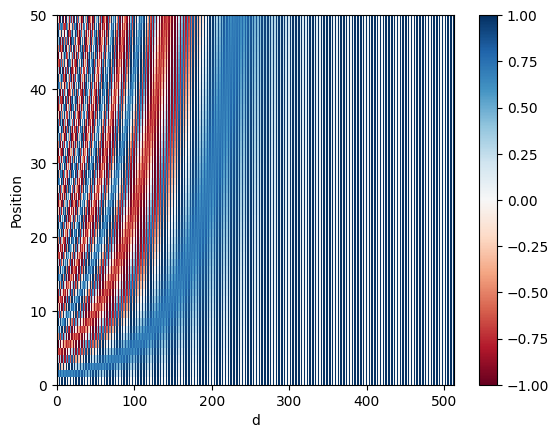

In [ ]:
# visualize positional encodings
pos_encoding = positional_encoding(50, 512)
print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('d')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

Each row in the positional encoding matrix corresponds to a specific position in the input sequence. Since each position receives a unique encoding, the model can distinguish between the order of tokens, even when processing the sequence in parallel.

---

## 2. Masking Strategies in Transformers

When building a Transformer model, certain tokens should be ignored during attention calculations to prevent misleading results. Two common masking strategies are used:

- **Padding Mask**: Ignores padding tokens added for sequence alignment.
- **Look-Ahead Mask**: Prevents the model from attending to future tokens during decoding (used in autoregressive tasks like translation).

---

### Padding Mask

In real-world NLP projects, input sequences will likely vary in length. However, Transformer models expect inputs of a fixed size. To align these sequences, shorter sequences are padded with zeros, and longer ones may be truncated:

**Example:**

Original tokenized input:
```plaintext
[[ 71, 121,   4,  56,  99, 2344,  345, 1284,   15],
 [ 56, 1285,  15, 181, 545],
 [ 87,  600]]
```

After padding to a fixed length of 5:
```plaintext
[[ 71, 121,   4,  56,  99],
 [2344,  345, 1284,   15,    0],
 [ 56, 1285,   15, 181,  545],
 [ 87,  600,    0,   0,    0]]
```

The padding values (`0`) are not meaningful inputs. If they were included in attention calculations, they would skew the output. Thats why we use a **padding mask** to assign very negative scores (like `-1e9`) to these positions before applying the softmax. This ensures they contribute essentially nothing to the attention output.

**Conceptually:**
- Input: `[87, 600, 0, 0, 0]`
- Masked: `[87, 600, -1e9, -1e9, -1e9]`
- After softmax, the masked values will have zero weight.

This approach is supported by many Transformer implementations, such as Keras’s [`MultiHeadAttention`](https://keras.io/api/layers/attention_layers/multi_head_attention/) layer, which accepts padding masks as input.

> Note: The function below generates a mask for an already padded sequence.
```




In [120]:
def create_padding_mask(decoder_token_ids):
    """
    Creates a matrix mask for the padding cells
    Arguments:
        decoder_token_ids -- (n, m) matrix
    Returns:
        mask -- (n, 1, m) binary tensor
    """
    seq = 1 - tf.cast(tf.math.equal(decoder_token_ids, 0), tf.float32)

    # add extra dimensions to add the padding
    # to the attention logits.
    # this will allow for broadcasting later when comparing sequences
    return seq[:, tf.newaxis, :]

In [121]:
x = tf.constant([[7., 6., 0., 0., 1.], [1., 2., 3., 0., 0.], [0., 0., 0., 4., 5.]])
print(create_padding_mask(x))

tf.Tensor(
[[[1. 1. 0. 0. 1.]]

 [[1. 1. 1. 0. 0.]]

 [[0. 0. 0. 1. 1.]]], shape=(3, 1, 5), dtype=float32)


In [122]:
print(tf.keras.activations.softmax(x))
print(tf.keras.activations.softmax(x + (1 - create_padding_mask(x)) * -1.0e9))

tf.Tensor(
[[7.2876638e-01 2.6809821e-01 6.6454895e-04 6.6454895e-04 1.8064313e-03]
 [8.4437370e-02 2.2952458e-01 6.2391245e-01 3.1062771e-02 3.1062771e-02]
 [4.8541022e-03 4.8541022e-03 4.8541022e-03 2.6502505e-01 7.2041267e-01]], shape=(3, 5), dtype=float32)
tf.Tensor(
[[[7.2973621e-01 2.6845497e-01 0.0000000e+00 0.0000000e+00 1.8088353e-03]
  [2.4472848e-01 6.6524088e-01 0.0000000e+00 0.0000000e+00 9.0030566e-02]
  [6.6483538e-03 6.6483538e-03 0.0000000e+00 0.0000000e+00 9.8670328e-01]]

 [[7.3057157e-01 2.6876229e-01 6.6619506e-04 0.0000000e+00 0.0000000e+00]
  [9.0030566e-02 2.4472848e-01 6.6524088e-01 0.0000000e+00 0.0000000e+00]
  [3.3333334e-01 3.3333334e-01 3.3333334e-01 0.0000000e+00 0.0000000e+00]]

 [[0.0000000e+00 0.0000000e+00 0.0000000e+00 2.6894143e-01 7.3105854e-01]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 5.0000000e-01 5.0000000e-01]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 2.6894143e-01 7.3105854e-01]]], shape=(3, 3, 5), dtype=float32)


### Look-Ahead Mask (Causal Masking)

In autoregressive tasks like language modeling or text generation, the model should not have access to future tokens when predicting the current one. This is where a **look-ahead mask** (AKA causal mask) is applied.

The look-ahead mask makes sure each position in the decoder can only attend to previous positions, not future ones.

---

**Conceptual Example:**

Suppose the true output sequence is:

[1, 2, 3]


During training, you don’t want the model to peek at positions 2 and 3 while predicting position 1. So, you apply a mask that hides future values at each time step:

| Step | Visible Input        | Masked Output         |
|------|----------------------|------------------------|
| 1    | `[1, -1e9, -1e9]`    | Predict token 1        |
| 2    | `[1, 2, -1e9]`       | Predict token 2        |
| 3    | `[1, 2, 3]`          | Predict token 3        |

This allows the model to simulate sequential prediction while still training in parallel.

Most modern Transformer libraries support this natively through a look-ahead or causal mask input.


In [123]:
def create_look_ahead_mask(sequence_length):
    """
    Returns a lower triangular matrix filled with ones
    Arguments:
        sequence_length -- matrix size
    Returns:
        mask -- (size, size) tensor
    """
    tf.random.set_seed(SEED)
    mask = tf.linalg.band_part(tf.ones((1, sequence_length, sequence_length)), -1, 0)
    return mask

In [124]:
x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(1, 3, 3), dtype=float32, numpy=
array([[[1., 0., 0.],
        [1., 1., 0.],
        [1., 1., 1.]]], dtype=float32)>

## 3. Self-Attention

Self-attention is a very important component of the Transformer architecture. It allows the model to weigh the relevance of every other token in the sequence when processing a particular token. Unlike traditional RNNs, self-attention is fully parallelizable, making it efficient for large-scale training.

<img src="../assets/self-attention.png" alt="Self-Attention Illustration" width="600"/>

In the Transformer model, **scaled dot-product attention** is used to calculate attention scores between tokens. Each token is projected into three different spaces to produce:

- **Queries (Q)**
- **Keys (K)**
- **Values (V)**

These are combined using the following equation:

$$
\text{Attention}(Q, K, V) = \operatorname{softmax}\left(\frac{Q K^{T}}{\sqrt{d_k}} + M\right) V \tag{4}
$$

Where:
- $Q$ is the matrix of queries
- $K$ is the matrix of keys
- $V$ is the matrix of values
- $M$ is an optional mask (ex: padding or look-ahead)
- $d_k$ is the dimensionality of the keys and is used for scaling

Scaling by $\sqrt{d_k}$ prevents the dot products from growing too large, which helps stabilize gradients when the softmax is applied.

---

### Implementing Scaled Dot-Product Attention

The implementation of scaled dot-product attention takes in query, key, value, and an optional mask. The mask is typically used to prevent attention to certain positions (ex: padding tokens or future tokens in the decoder).

When a mask is provided, we modify the attention logits by applying:

```python
masked_logits = logits + (1.0 - mask) * -1e9


In [137]:
def scaled_dot_product_attention(q, k, v, mask):
    """
    Calculate the attention weights.
      q, k, v must have matching leading dimensions.
      k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
      The mask has different shapes depending on its type(padding or look ahead)
      but it must be broadcastable for addition.
    Arguments:
        q -- query shape == (..., seq_len_q, depth)
        k -- key shape == (..., seq_len_k, depth)
        v -- value shape == (..., seq_len_v, depth_v)
        mask: Float tensor with shape broadcastable
              to (..., seq_len_q, seq_len_k). Defaults to None.
    Returns:
        output -- attention_weights
    """
    tf.random.set_seed(SEED)
    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None: # Don't replace this None
        scaled_attention_logits += (1.0 - mask)*-1e9

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights

In [126]:
# UNIT TEST
scaled_dot_product_attention_test(scaled_dot_product_attention)

All tests passed


With self-attention implemented, the next step is to build the Transformer encoder block.

---

## 4. Encoder Architecture

The Transformer encoder is composed of two main sub-layers:

1. **Multi-Head Self-Attention**  
2. **Feed-Forward Neural Network**

These components are stacked together with residual connections and layer normalization to create a powerful and scalable architecture. The encoder generates context-aware representations of the input tokens and passes key and value vectors to the decoder.

<img src="../assets/encoder_layer.png" alt="Transformer Encoder Layer" width="400"/>

In this setup:
- The **Multi-Head Attention** layer allows the model to jointly attend to information from different representation subspaces.
- The **Feed-Forward Network (FFN)** consists of two dense layers, applied independently to each position in the sequence.

---

### Encoder Block Design

1. **Multi-Head Self-Attention**  
   - Allows the encoder to look at all positions in the input sequence when processing each token.
   - Allows learning multiple types of relationships by using multiple attention heads.
   - Implemented using [`tf.keras.layers.MultiHeadAttention`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MultiHeadAttention)

2. **Feed-Forward Network**  
   - A small two-layer neural network applied identically to each position.
   - Typically includes a ReLU or GELU activation between the dense layers.
   - Implemented using the [Keras Sequential API](https://keras.io/api/models/sequential/)

The attention output is first passed through a dropout and normalization layer before being added back to the original input (residual connection). The same pattern is repeated after the FFN. This structure is repeated in multiple encoder layers to form the full Transformer encoder stack.


In [127]:
def FullyConnected(embedding_dim, fully_connected_dim):
    tf.random.set_seed(SEED)
    return tf.keras.Sequential([tf.keras.layers.Dense(fully_connected_dim, activation='relu'), # (batch_size, seq_len, dff)
                                tf.keras.layers.Dense(embedding_dim)]) # (batch_size, seq_len, embedding_dim)


### 4.1. Building the Encoder Layer

With the core components in place, I can now make a full encoder layer by combining:

- Multi-head self-attention
- Feed-forward neural network (FFN)
- Residual connections
- Layer normalization
- Dropout for regularization

This structure mirrors the standard encoder block design introduced in the original Transformer paper. A diagram of the layer structure is shown below:

<img src="../assets/encoder_layer.png" alt="Encoder Layer Diagram" width="400"/>

---

### Encoder Layer Implementation Overview

The encoder layer operates as follows:

1. **Self-Attention**  
   The input is passed through a multi-head self-attention mechanism. For self-attention, the query, key, and value inputs are all the same (`Q = K = V`). An optional mask can be applied here to ignore specific tokens (e.g., padding).

2. **Residual Connection + Normalization**  
   A skip connection is added between the input and the attention output. This sum is then passed through a layer normalization layer.

3. **Feed-Forward Network**  
   The output is then passed through a small two-layer feed-forward neural network. Dropout is applied for regularization.

4. **Second Residual Connection + Normalization**  
   Another skip connection is applied between the FFN input and its output, followed by a second layer normalization.

This design allows each encoder block to build increasingly rich representations of the input, while the residual connections help with gradient flow during training.




In [128]:
# from tensorflow.keras.layers import LayerNormalization, Dropout, MultiHeadAttention, Dense

class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, embedding_dim, num_heads, fully_connected_dim,
                 dropout_rate=0.1, layernorm_eps=1e-6):
        super(EncoderLayer, self).__init__()

        tf.random.set_seed(SEED)  # Set seed before defining layers

        # Fix the initializer for MultiHeadAttention
        self.mha = MultiHeadAttention(num_heads=num_heads,
                                      key_dim=embedding_dim,
                                      dropout=dropout_rate,
                                      kernel_initializer=tf.keras.initializers.GlorotUniform(seed=SEED))

        # Fix the initializer for FullyConnected layers
        self.ffn = tf.keras.Sequential([Dense(fully_connected_dim, activation='relu',kernel_initializer=tf.keras.initializers.GlorotUniform(seed=SEED)),
                                        Dense(embedding_dim, kernel_initializer=tf.keras.initializers.GlorotUniform(seed=SEED))])

        # Fix the initializer for LayerNormalization
        self.layernorm1 = LayerNormalization(epsilon=layernorm_eps)
        self.layernorm2 = LayerNormalization(epsilon=layernorm_eps)

        # Fix the Dropout seed
        self.dropout_ffn = Dropout(dropout_rate, seed=SEED)

    def call(self, x, training, mask):
        tf.random.set_seed(SEED)  # Ensure deterministic behavior at every call

        self_mha_output = self.mha(query=x, value=x, key=x, attention_mask=mask, return_attention_scores=False, training=training)

        # Skip connection + LayerNorm
        skip_x_attention = self.layernorm1(x + self_mha_output)

        # Pass through feedforward
        ffn_output = self.ffn(skip_x_attention)

        # Apply dropout (only during training)
        ffn_output = self.dropout_ffn(ffn_output, training=training)

        # Final layer norm
        encoder_layer_out = self.layernorm2(skip_x_attention + ffn_output)
        print(encoder_layer_out)

        return encoder_layer_out


In [129]:
# UNIT TEST
tf.random.set_seed(SEED)
EncoderLayer_test(EncoderLayer)

Tensor("layer_normalization_34_1/add_2:0", shape=(1, 3, 4), dtype=float32)
tf.Tensor(
[[[ 0.9754241   0.15179627  0.52959394 -1.6568143 ]
  [-0.24592474  0.44221142  1.266537   -1.4628237 ]
  [ 1.6900113  -0.35137552 -0.41989863 -0.9187371 ]]], shape=(1, 3, 4), dtype=float32)
tf.Tensor(
[[[ 0.7332504   0.01539418  0.8870007  -1.6356452 ]
  [-0.4855674   0.33046782  1.4271767  -1.2720772 ]
  [ 1.6128805  -0.39568523 -0.10796562 -1.1092294 ]]], shape=(1, 3, 4), dtype=float32)
All tests passed


### Building the Full Transformer Encoder

Now, the key components of the Transformer encoder are implemented: positional encodings, scaled dot-product self-attention, and a single encoder layer. Next, I bring everything together to build the **full encoder block** which is the backbone of the Transformer architecture.

The full encoder consists of:

- An embedding layer to convert token indices into dense vectors
- Positional encodings added to the embeddings to incorporate order
- A stack of multiple encoder layers
- Dropout and scaling applied at key steps to improve regularization and training stability

<img src="../assets/encoder.png" alt="Full Transformer Encoder" width="330"/>

---

### Encoder Class Overview

The encoder module follows this sequence of operations:

1. **Embedding**  
   The input token indices are passed through an `Embedding` layer to produce dense vector representations.

2. **Embedding Scaling**  
   The output of the embedding layer is scaled by $\sqrt{d_{\text{model}}}$ to prevent small initialization values from slowing down training. Be sure to cast `d_model` to `tf.float32` before the square root.

3. **Positional Encoding**  
   Positional information is added by summing the embeddings with a precomputed positional encoding matrix:  
   ```python
   x += self.pos_encoding[:, :seq_len, :]
   ```

4. **Dropout**  
   A `Dropout` layer is applied after the positional encoding for regularization during training. 

5. **Encoder Layer Stack**  
   The result is passed through a sequence of encoder layers (already defined) using a for loop. Each encoder layer is responsible for refining the input representations via multi-head attention and a feed forward network.

This stacked architecture makes the encoder capture increasingly abstract relationships between tokens across the input sequence.

The encoder can be reused in a variety of tasks, including machine translation, classification, and language modeling.


In [130]:
from tensorflow.keras.layers import Embedding, Dropout
import tensorflow as tf

class Encoder(tf.keras.layers.Layer):
    """
    The entire Encoder starts by passing the input to an embedding layer
    and using positional encoding to then pass the output through a stack of
    encoder Layers.
    """
    def __init__(self, num_layers, embedding_dim, num_heads, fully_connected_dim, input_vocab_size,
                 maximum_position_encoding, dropout_rate=0.1, layernorm_eps=1e-6):
        super(Encoder, self).__init__()
        tf.random.set_seed(SEED)  # Set seed before defining layers

        self.embedding_dim = embedding_dim
        self.num_layers = num_layers

        # Use a fixed initializer with the seed for reproducibility
        self.embedding = Embedding(input_vocab_size, self.embedding_dim,
                                   embeddings_initializer=tf.keras.initializers.GlorotUniform(seed=SEED))

        self.pos_encoding = positional_encoding(maximum_position_encoding, self.embedding_dim)

        # Create EncoderLayer instances (each with its own reproducibility settings)
        self.enc_layers = [EncoderLayer(embedding_dim=self.embedding_dim,
                                        num_heads=num_heads,
                                        fully_connected_dim=fully_connected_dim,
                                        dropout_rate=dropout_rate,
                                        layernorm_eps=layernorm_eps)
                           for _ in range(self.num_layers)]

        # Initialize dropout with a fixed seed
        self.dropout = Dropout(dropout_rate, seed=SEED)

    def call(self, x, training, mask):
        # Do not reset the seed here; rely on the seed set once during initialization.
        seq_len = tf.shape(x)[1]

        # Pass input through the Embedding layer and scale it
        x = self.embedding(x)  # (batch_size, input_seq_len, embedding_dim)
        x *= tf.math.sqrt(tf.cast(self.embedding_dim, tf.float32))
        # Add positional encoding
        x += self.pos_encoding[:, :seq_len, :]
        # Apply dropout (only during training)
        x = self.dropout(x, training=training)
        # Pass through the stack of encoder layers
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training=training, mask=mask)
        return x  # (batch_size, input_seq_len, embedding_dim)


## 5. Transformer Decoder

The decoder is responsible for generating the output sequence, one token at a time, during autoregressive tasks such as translation or text generation. It processes the output sequence (shifted right during training) while attending to the encoder's outputs.

The decoder layer incorporates two multi-head attention blocks:

1. A self-attention layer that uses a look-ahead mask to prevent attending to future positions.
2. A cross-attention layer that attends to the encoder’s key and value outputs using the current decoder state as the query.

<img src="../assets/decoder_layer.png" alt="Transformer Decoder Layer" width="250"/>

---

### Decoder Layer Design

Each decoder layer follows a similar structure to the encoder but includes an additional self-attention block at the beginning.

The layer consists of three sub-blocks:

#### **Block 1: Masked Self-Attention**
- Applies a look-ahead mask so that each position can only attend to previous positions in the output sequence.
- This simulates autoregressive generation during training.
- A residual connection and layer normalization follow the attention output.

#### **Block 2: Encoder-Decoder Cross-Attention**
- Calculates attention between the decoder’s current representation and the encoder's output.
- The query comes from the decoder, while keys and values come from the encoder.
- This allows the decoder to align its output generation with the encoded input.
- A second residual connection and normalization are applied.

#### **Block 3: Feed-Forward Network**
- Similar to the encoder, a two-layer dense network is applied independently to each position.
- Dropout is included for regularization, and another residual connection with layer normalization is applied.

Each decoder layer allows the model to combine knowledge from both the input and previously generated tokens, allowing for flexible and powerful sequence generation. Multiple decoder layers are stacked to form the full Transformer decoder.


In [131]:
class DecoderLayer(tf.keras.layers.Layer):
    """
    The decoder layer is composed by two multi-head attention blocks,
    one that takes the new input and uses self-attention, and the other
    one that combines it with the output of the encoder, followed by a
    fully connected block.
    """
    def __init__(self, embedding_dim, num_heads, fully_connected_dim, dropout_rate=0.1, layernorm_eps=1e-6):
        super(DecoderLayer, self).__init__()

        tf.random.set_seed(SEED)  # Set seed before defining layers

        self.mha1 = MultiHeadAttention(num_heads=num_heads,
                                      key_dim=embedding_dim,
                                      dropout=dropout_rate,
                                      kernel_initializer=tf.keras.initializers.GlorotUniform(seed=SEED))

        self.mha2 = MultiHeadAttention(num_heads=num_heads,
                                      key_dim=embedding_dim,
                                      dropout=dropout_rate,
                                      kernel_initializer=tf.keras.initializers.GlorotUniform(seed=SEED))
        for layer in self.mha1.trainable_variables:
          layer.assign(tf.keras.initializers.GlorotUniform(seed=SEED)(shape=layer.shape))

        for layer in self.mha2.trainable_variables:
          layer.assign(tf.keras.initializers.GlorotUniform(seed=SEED)(shape=layer.shape))

        self.ffn = FullyConnected(embedding_dim=embedding_dim,
                                  fully_connected_dim=fully_connected_dim,
                                 )

        self.layernorm1 = LayerNormalization(epsilon=layernorm_eps)
        self.layernorm2 = LayerNormalization(epsilon=layernorm_eps)
        self.layernorm3 = LayerNormalization(epsilon=layernorm_eps)

        self.dropout_ffn = Dropout(dropout_rate, seed=SEED)

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        """
        Forward pass for the Decoder Layer
        Arguments:
            x -- Tensor of shape (batch_size, target_seq_len, embedding_dim)
            enc_output --  Tensor of shape(batch_size, input_seq_len, embedding_dim)
            training -- Boolean, set to true to activate
                        the training mode for dropout layers
            look_ahead_mask -- Boolean mask for the target_input
            padding_mask -- Boolean mask for the second multihead attention layer
        Returns:
            out3 -- Tensor of shape (batch_size, target_seq_len, embedding_dim)
            attn_weights_block1 -- Tensor of shape(batch_size, num_heads, target_seq_len, input_seq_len)
            attn_weights_block2 -- Tensor of shape(batch_size, num_heads, target_seq_len, input_seq_len)
        """
        # enc_output.shape == (batch_size, input_seq_len, embedding_dim)

        # BLOCK 1
        # calculate self-attention and return attention scores as attn_weights_block1.
        # Dropout will be applied during training (~1 line).
        mult_attn_out1, attn_weights_block1 = self.mha1(query=x,
                                                        value=x,
                                                        key=x,
                                                        attention_mask=look_ahead_mask,
                                                        return_attention_scores=True)  # (batch_size, target_seq_len, embedding_dim)

        # apply layer normalization (layernorm1) to the sum of the attention output and the input (~1 line)
        Q1 = self.layernorm1(x + mult_attn_out1)

        # BLOCK 2
        # calculate self-attention using the Q from the first block and K and V from the encoder output.
        # Dropout will be applied during training
        # Return attention scores as attn_weights_block2 (~1 line)
        mult_attn_out2, attn_weights_block2 = self.mha2(query=Q1,
                                                        value=enc_output,
                                                        key=enc_output,
                                                        attention_mask=padding_mask,
                                                        return_attention_scores=True)  # (batch_size, target_seq_len, embedding_dim)

        # apply layer normalization (layernorm2) to the sum of the attention output and the output of the first block (~1 line)
        mult_attn_out2 = self.layernorm2(Q1 + mult_attn_out2)  # (batch_size, target_seq_len, embedding_dim)

        #BLOCK 3
        # pass the output of the second block through a ffn
        ffn_output = self.ffn(mult_attn_out2)  # (batch_size, target_seq_len, embedding_dim)

        # apply a dropout layer to the ffn output
        # use `training=training`
        ffn_output = self.dropout_ffn(ffn_output, training=training)

        # apply layer normalization (layernorm3) to the sum of the ffn output and the output of the second block
        out3 = self.layernorm3(mult_attn_out2 + ffn_output) # (batch_size, target_seq_len, embedding_dim)

        return out3, attn_weights_block1, attn_weights_block2


In [132]:
# UNIT TEST
DecoderLayer_test(DecoderLayer, create_look_ahead_mask)

All tests passed


### Building the Full Transformer Decoder

The full decoder module combines all components developed so far: token embeddings, positional encodings, and a stack of decoder layers to generate output sequences autoregressively.

The decoder receives the target sequence as input (typically shifted right during training), embeds it, adds positional information, and processes it through multiple decoder layers. Each decoder layer applies masked self-attention, cross-attention with encoder outputs, and a feed-forward network.

<img src="../assets/decoder.png" alt="Transformer Decoder Architecture" width="300"/>


### Decoder Structure

The decoder follows these steps:

1. **Embedding Layer**  
   Converts the token indices from the target sequence into dense vector representations using a learned embedding matrix.

2. **Embedding Scaling**  
   The embedding vectors are scaled by $\sqrt{d_{\text{model}}}$ to control the variance and stabilize training.

3. **Positional Encoding**  
   The positional encoding is added to the scaled embeddings to inject information about token order.

4. **Dropout**  
   Dropout is applied after the positional encoding to prevent overfitting during training.

5. **Stack of Decoder Layers**  
   The encoded input is passed through a stack of identical decoder layers. Each layer includes:
   - Masked self-attention (with look-ahead mask)
   - Cross-attention with encoder outputs
   - Feed-forward network
   - Residual connections and normalization

The decoder can be used for tasks such as machine translation, text summarization, or any sequence generation problem where context from an input sequence is needed to condition the output.


In [133]:
class Decoder(tf.keras.layers.Layer):
    """
    The entire Encoder starts by passing the target input to an embedding layer
    and using positional encoding to then pass the output through a stack of
    decoder Layers
    """
    def __init__(self, num_layers, embedding_dim, num_heads, fully_connected_dim, target_vocab_size,
               maximum_position_encoding, dropout_rate=0.1, layernorm_eps=1e-6):
        super(Decoder, self).__init__()
        tf.random.set_seed(SEED)  # Set seed before defining layers

        self.embedding_dim = embedding_dim
        self.num_layers = num_layers

        self.embedding = Embedding(target_vocab_size, self.embedding_dim)
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.embedding_dim)

        self.dec_layers = [DecoderLayer(embedding_dim=self.embedding_dim,
                                        num_heads=num_heads,
                                        fully_connected_dim=fully_connected_dim,
                                        dropout_rate=dropout_rate,
                                        layernorm_eps=layernorm_eps)
                           for _ in range(self.num_layers)]

        self.dropout = Dropout(dropout_rate, seed=SEED)

    def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):
        """
        Forward  pass for the Decoder

        Arguments:
            x -- Tensor of shape (batch_size, target_seq_len, embedding_dim)
            enc_output --  Tensor of shape(batch_size, input_seq_len, embedding_dim)
            training -- Boolean, set to true to activate
                        the training mode for dropout layers
            look_ahead_mask -- Boolean mask for the target_input
            padding_mask -- Boolean mask for the second multihead attention layer
        Returns:
            x -- Tensor of shape (batch_size, target_seq_len, embedding_dim)
            attention_weights - Dictionary of tensors containing all the attention weights
                                each of shape Tensor of shape (batch_size, num_heads, target_seq_len, input_seq_len)
        """

        seq_len = tf.shape(x)[1]
        attention_weights = {}

        # create word embeddings
        x = self.embedding(x)  # (batch_size, target_seq_len, embedding_dim)

        # scale embeddings by multiplying by the square root of their dimension
        x *= tf.math.sqrt(tf.cast(self.embedding_dim, tf.float32))

        # calculate positional encodings and add to word embedding
        x += self.pos_encoding[:, :seq_len, :]

        # apply a dropout layer to x
        # use `training=training`
        x = self.dropout(x, training=training)

        # use a for loop to pass x through a stack of decoder layers and update attention_weights (~4 lines total)
        for i in range(self.num_layers):
            # pass x and the encoder output through a stack of decoder layers and save the attention weights
            # of block 1 and 2 (~1 line)
            x, block1, block2 = self.dec_layers[i](x=x, enc_output=enc_output, training=training, look_ahead_mask=look_ahead_mask, padding_mask=padding_mask)

            #update attention_weights dictionary with the attention weights of block 1 and block 2
            attention_weights['decoder_layer{}_block1_self_att'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2_decenc_att'.format(i+1)] = block2
        #x.shape == (batch_size, target_seq_len, embedding_dim)
        return x, attention_weights

In [134]:
# # UNIT TEST
Decoder_test(Decoder, create_look_ahead_mask, create_padding_mask)

All tests passed


## 6. Assembling the Full Transformer Model

The Transformer architecture brings together the encoder and decoder components into a unified model designed for sequence-to-sequence tasks. This includes applications like machine translation, summarization, and question answering.

The full model consists of stacked encoder and decoder layers, along with a final dense output layer that generates predictions.

<img src="../assets/transformer.png" alt="Full Transformer Architecture" width="550"/>

### Architecture Flow

1. **Input → Encoder**  
   The source input sequence is first passed through the encoder, which consists of:
   - Token embeddings
   - Positional encodings
   - Multiple stacked encoder layers (each with multi-head self-attention and feed-forward networks)

2. **Target → Decoder**  
   The target sequence (shifted during training) is passed through the decoder:
   - Token embeddings and positional encodings are applied to the target
   - Masked self-attention is used to prevent the decoder from attending to future tokens
   - Cross-attention integrates information from the encoder’s output
   - A feed-forward network further refines each decoder layer’s output

3. **Output Layer**  
   The final decoder output is passed through a linear `Dense` layer, followed by a `softmax` activation to generate token level predictions over the vocabulary.


### Transformer Class Design

The main model combines all components into a single `Transformer` class, which performs the following steps in the `call()` method:

1. Pass the input sequence through the encoder using the appropriate padding mask.
2. Pass the encoder output and target sequence through the decoder, using both the look-ahead and padding masks.
3. Apply a final linear projection to the decoder’s output.
4. Use a `softmax` activation to produce a probability distribution over the vocabulary for each position in the output.

This modular design allows flexibility for reuse across a variety of NLP tasks and training strategies.


In [135]:
class Transformer(tf.keras.Model):
    """
    Complete transformer with an Encoder and a Decoder
    """
    def __init__(self, num_layers, embedding_dim, num_heads, fully_connected_dim, input_vocab_size,
               target_vocab_size, max_positional_encoding_input,
               max_positional_encoding_target, dropout_rate=0.1, layernorm_eps=1e-6):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers=num_layers,
                               embedding_dim=embedding_dim,
                               num_heads=num_heads,
                               fully_connected_dim=fully_connected_dim,
                               input_vocab_size=input_vocab_size,
                               maximum_position_encoding=max_positional_encoding_input,
                               dropout_rate=dropout_rate,
                               layernorm_eps=layernorm_eps)

        self.decoder = Decoder(num_layers=num_layers,
                               embedding_dim=embedding_dim,
                               num_heads=num_heads,
                               fully_connected_dim=fully_connected_dim,
                               target_vocab_size=target_vocab_size,
                               maximum_position_encoding=max_positional_encoding_target,
                               dropout_rate=dropout_rate,
                               layernorm_eps=layernorm_eps)

        self.final_layer = Dense(target_vocab_size, activation='softmax')

    def call(self, input_sentence, output_sentence, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        """
        Forward pass for the entire Transformer
        Arguments:
            input_sentence -- Tensor of shape (batch_size, input_seq_len)
                              An array of the indexes of the words in the input sentence
            output_sentence -- Tensor of shape (batch_size, target_seq_len)
                              An array of the indexes of the words in the output sentence
            training -- Boolean, set to true to activate
                        the training mode for dropout layers
            enc_padding_mask -- Boolean mask to ensure that the padding is not
                    treated as part of the input
            look_ahead_mask -- Boolean mask for the target_input
            dec_padding_mask -- Boolean mask for the second multihead attention layer
        Returns:
            final_output -- Describe me
            attention_weights - Dictionary of tensors containing all the attention weights for the decoder
                                each of shape Tensor of shape (batch_size, num_heads, target_seq_len, input_seq_len)
        """
        # call self.encoder with the appropriate arguments to get the encoder output
        enc_output = self.encoder(x=input_sentence, training=training, mask=enc_padding_mask)  # (batch_size, inp_seq_len, embedding_dim)

        # call self.decoder with the appropriate arguments to get the decoder output
        # dec_output.shape == (batch_size, tar_seq_len, embedding_dim)
        dec_output, attention_weights = self.decoder(x=output_sentence, enc_output=enc_output, training=training, look_ahead_mask=look_ahead_mask, padding_mask=dec_padding_mask)

        # pass decoder output through a linear layer and softmax (~2 lines)
        final_output = self.final_layer(dec_output) # (batch_size, tar_seq_len, target_vocab_size)

        return final_output, attention_weights

In [136]:
# UNIT TEST
Transformer_test(Transformer, create_look_ahead_mask, create_padding_mask)

Tensor("layer_normalization_60_1/add_2:0", shape=(1, 5, 4), dtype=float32)
Tensor("encoder_layer_4_1/layer_normalization_60_1/add_2:0", shape=(1, 5, 4), dtype=float32)
Tensor("layer_normalization_62_1/add_2:0", shape=(1, 5, 4), dtype=float32)
Tensor("encoder_layer_5_1/layer_normalization_62_1/add_2:0", shape=(1, 5, 4), dtype=float32)
Tensor("layer_normalization_64_1/add_2:0", shape=(1, 5, 4), dtype=float32)
Tensor("encoder_layer_6_1/layer_normalization_64_1/add_2:0", shape=(1, 5, 4), dtype=float32)
Tensor("layer_normalization_66_1/add_2:0", shape=(1, 5, 4), dtype=float32)
Tensor("encoder_layer_7_1/layer_normalization_66_1/add_2:0", shape=(1, 5, 4), dtype=float32)
Tensor("layer_normalization_68_1/add_2:0", shape=(1, 5, 4), dtype=float32)
Tensor("encoder_layer_8_1/layer_normalization_68_1/add_2:0", shape=(1, 5, 4), dtype=float32)
Tensor("layer_normalization_70_1/add_2:0", shape=(1, 5, 4), dtype=float32)
Tensor("encoder_layer_9_1/layer_normalization_70_1/add_2:0", shape=(1, 5, 4), dtype=f

## Conclusion

This notebook explored the inner workings of the Transformer architecture by implementing it from the ground up. Key components such as positional encoding, self-attention, and multi-head attention were developed and integrated into full encoder and decoder modules. Through this process, the final model closely mirrors the original Transformer architecture introduced by Vaswani et al. and provides a foundation for further experimentation with advanced NLP tasks.

### Key Takeaways

- **Self-Attention** enables each token to dynamically focus on other tokens in the sequence, regardless of position.
- **Multi-Head Attention** improves the model’s ability to capture different contextual relationships by learning multiple attention distributions in parallel.
- **Positional Encoding** injects order information into input embeddings, which is crucial for understanding sequential data in a parallel architecture.
- **Residual Connections and Layer Normalization** help stabilize training and preserve gradient flow in deep architectures.
- **Masking** allows the model to ignore padded tokens or restrict future token access during training (causal masking).

The resulting architecture is highly parallelizable and good for use in modern NLP tasks.


### Next Steps

With the core Transformer structure implemented, this model can now be extended and applied to real-world problems such as:

- **Named Entity Recognition (NER)**
- **Extractive Question Answering**
- **Text Summarization**
- **Sequence Classification**

The encoder and decoder modules developed here can be fine-tuned or enhanced for these applications in downstream notebooks.

---

## References

- Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., Kaiser, L., & Polosukhin, I. (2017).  
  [Attention Is All You Need](https://arxiv.org/abs/1706.03762). *Advances in Neural Information Processing Systems*.
